In [ ]:
!python -m pip install --upgrade pip
%pip install pandas matplotlib seaborn scikit-learn openpyxl tensorflow xgboost aif360
%pip install "aif360[Reductions, inFairness]"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import chi2_contingency, fisher_exact
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression,                 LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, BatchNormalization # type: ignore

from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.algorithms.preprocessing import LFR
from fairlearn.preprocessing import CorrelationRemover
from aif360.algorithms.inprocessing import GerryFairClassifier, PrejudiceRemover, MetaFairClassifier
from aif360.algorithms.postprocessing import EqOddsPostprocessing, RejectOptionClassification

from fairlearn.metrics import MetricFrame
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference, selection_rate, false_positive_rate, false_negative_rate, count
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

random_seed = 15

c:\Users\andre\Desktop\ProjectWork_AEQUITAS_AKKODIS\.venv\lib\site-packages\inFairness\utils\ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
c:\Users\andre\Desktop\ProjectWork_AEQUITAS_AKKODIS\.venv\lib\site-packages\inFairness\utils\ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.

In [194]:
PATH = 'C:/Users/andre/Desktop/ProjectWork_AEQUITAS_AKKODIS/'
df = (
    pd.read_excel(PATH + 'data/Dataset_2.0_Akkodis.xlsx')
      .rename(columns=lambda c: c.lstrip().title())
)
df.head()

,Id,Candidate State,Age Range,Residence,Sex,Protected Category,Tag,Study Area,Study Title,Years Experience,...,Akkodis Headquarters,Current Ral,Expected Ral,Technical Skills,Standing/Position,Comunication,Maturity,Dynamism,Mobility,English
0,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],...,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],...,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],...,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],...,Modena,22-24 K,24-26 K,2.0,2.0,1.0,2.0,2.0,3.0,3.0
4,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],...,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Preprocessing

### Clean Dataset

In [195]:
df = df.drop_duplicates(subset='Id', keep='last')
df.head()

,Id,Candidate State,Age Range,Residence,Sex,Protected Category,Tag,Study Area,Study Title,Years Experience,...,Akkodis Headquarters,Current Ral,Expected Ral,Technical Skills,Standing/Position,Comunication,Maturity,Dynamism,Mobility,English
5,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],...,Modena,22-24 K,24-26 K,3.0,2.0,2.0,3.0,3.0,2.0,4.0
11,21020,Vivier,40 - 45 years,CONVERSANO » Bari ~ Puglia,Female,NaN,"-, C, C++, DO178, LABVIEW, SOFTWARE DEVELOPMENT",computer engineering,Five-year degree,[7-10],...,NaN,24-26 K,26-28 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,27054,QM,36 - 40 years,CASERTA » Caserta ~ Campania,Male,NaN,PROCESS ENG.,chemical engineering,Five-year degree,[3-5],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,27966,QM,> 45 years,SESTO SAN GIOVANNI » Milan ~ Lombardy,Male,NaN,"CISCO, NOC DAS SUPPORT, SOC",Legal,Five-year degree,[7-10],...,NaN,20-22 K,20-22 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,48399,In selection,31 - 35 years,MAZARA DEL VALLO » Trapani ~ Sicily,Male,NaN,"CALIBRATION, CAN, DYANALIZER, GT POWER, HIL, M...",Mechanical engineering,Five-year degree,[3-5],...,NaN,NaN,24-26 K,3.0,2.0,2.0,2.0,3.0,1.0,1.0


In [196]:
for feature in df.columns:
    print(f'Feature: {feature} -- {list(df[feature].unique())}')

Feature: Id -- [71470, 21020, 27054, 27966, 48399, 64130, 25155, 36032, 12574, 61565, 11885, 13394, 11099, 70630, 6640, 44920, 2852, 16281, 32429, 68008, 52104, 50891, 74627, 69504, 49879, 19760, 75322, 8301, 36405, 44063, 26421, 48346, 10339, 953, 59800, 20073, 30502, 8366, 69351, 5498, 7801, 57767, 4902, 57574, 48448, 43063, 80726, 17258, 168, 65155, 25398, 51803, 80242, 7156, 42490, 10890, 9387, 1301, 562, 372, 63022, 423, 28288, 51000, 19829, 47974, 9283, 16692, 59818, 47018, 23612, 39358, 19784, 67809, 45822, 13193, 49641, 69363, 37500, 31365, 31701, 54903, 18720, 12047, 41630, 60318, 77841, 38145, 77407, 41467, 10101, 72227, 22129, 69918, 76764, 35264, 49922, 14763, 11659, 60292, 58990, 74662, 12251, 70752, 53914, 17044, 47903, 16212, 21474, 7996, 17553, 12233, 70642, 43120, 49429, 22025, 38167, 24568, 23369, 55516, 76391, 77779, 27198, 64614, 60340, 9864, 62790, 71369, 24268, 20397, 56566, 76854, 47806, 56764, 34548, 44930, 34835, 71602, 62769, 33153, 36053, 5820, 36519, 30876, 

In [197]:
unuseful_columns = [
    'Id', 'Tag', 'Year Of Insertion',
    'Year Of Recruitment', 'Recruitment Request', 'Assumption Headquarters',
    'Event_Type__Val', 'Linked_Search__Key', 'Job Description', 
    'Candidate Profile', 'Akkodis Headquarters', 'Standing/Position', 'Last Role', 'Study Area.1',
    'Years Experience.1']
df = df.drop(columns=unuseful_columns)
df.head()

,Candidate State,Age Range,Residence,Sex,Protected Category,Study Area,Study Title,Years Experience,Sector,Job Family Hiring,...,Ral Maximum,Study Level,Current Ral,Expected Ral,Technical Skills,Comunication,Maturity,Dynamism,Mobility,English
5,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Engineering,...,30-32K,Five-year degree,22-24 K,24-26 K,3.0,2.0,3.0,3.0,2.0,4.0
11,Vivier,40 - 45 years,CONVERSANO » Bari ~ Puglia,Female,NaN,computer engineering,Five-year degree,[7-10],Aeronautics,NaN,...,NaN,NaN,24-26 K,26-28 K,NaN,NaN,NaN,NaN,NaN,NaN
13,QM,36 - 40 years,CASERTA » Caserta ~ Campania,Male,NaN,chemical engineering,Five-year degree,[3-5],Consulting,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,QM,> 45 years,SESTO SAN GIOVANNI » Milan ~ Lombardy,Male,NaN,Legal,Five-year degree,[7-10],Telecom,NaN,...,NaN,NaN,20-22 K,20-22 K,NaN,NaN,NaN,NaN,NaN,NaN
25,In selection,31 - 35 years,MAZARA DEL VALLO » Trapani ~ Sicily,Male,NaN,Mechanical engineering,Five-year degree,[3-5],Automotive,NaN,...,NaN,NaN,NaN,24-26 K,3.0,2.0,2.0,3.0,1.0,1.0


In [198]:
THRESHOLD = 100.0
unuseful_columns = []
for col in df.columns:
  null_count = df[col].isna().sum() / df.shape[0]
  if null_count > THRESHOLD:
    unuseful_columns.append(col)
    print(f'DROPPED <Column: {col}> NULL count: {null_count*100:.2f}%')
  else:
    print(f'<Column: {col}> NULL count: {null_count*100:.2f}%')
  
df = df.drop(columns=unuseful_columns)
df.head()

<Column: Candidate State> NULL count: 0.00%


<Column: Age Range> NULL count: 0.00%
<Column: Residence> NULL count: 0.01%
<Column: Sex> NULL count: 0.00%
<Column: Protected Category> NULL count: 99.64%
<Column: Study Area> NULL count: 0.32%
<Column: Study Title> NULL count: 0.00%
<Column: Years Experience> NULL count: 0.00%
<Column: Sector> NULL count: 59.45%
<Column: Job Family Hiring> NULL count: 96.37%
<Column: Job Title Hiring> NULL count: 96.37%
<Column: Event_Feedback> NULL count: 85.66%
<Column: Overall> NULL count: 84.42%
<Column: Minimum Ral> NULL count: 98.30%
<Column: Ral Maximum> NULL count: 97.78%
<Column: Study Level> NULL count: 96.87%
<Column: Current Ral> NULL count: 88.32%
<Column: Expected Ral> NULL count: 88.47%
<Column: Technical Skills> NULL count: 84.50%
<Column: Comunication> NULL count: 84.50%
<Column: Maturity> NULL count: 84.47%
<Column: Dynamism> NULL count: 84.47%
<Column: Mobility> NULL count: 84.45%
<Column: English> NULL count: 84.51%


,Candidate State,Age Range,Residence,Sex,Protected Category,Study Area,Study Title,Years Experience,Sector,Job Family Hiring,...,Ral Maximum,Study Level,Current Ral,Expected Ral,Technical Skills,Comunication,Maturity,Dynamism,Mobility,English
5,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Engineering,...,30-32K,Five-year degree,22-24 K,24-26 K,3.0,2.0,3.0,3.0,2.0,4.0
11,Vivier,40 - 45 years,CONVERSANO » Bari ~ Puglia,Female,NaN,computer engineering,Five-year degree,[7-10],Aeronautics,NaN,...,NaN,NaN,24-26 K,26-28 K,NaN,NaN,NaN,NaN,NaN,NaN
13,QM,36 - 40 years,CASERTA » Caserta ~ Campania,Male,NaN,chemical engineering,Five-year degree,[3-5],Consulting,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,QM,> 45 years,SESTO SAN GIOVANNI » Milan ~ Lombardy,Male,NaN,Legal,Five-year degree,[7-10],Telecom,NaN,...,NaN,NaN,20-22 K,20-22 K,NaN,NaN,NaN,NaN,NaN,NaN
25,In selection,31 - 35 years,MAZARA DEL VALLO » Trapani ~ Sicily,Male,NaN,Mechanical engineering,Five-year degree,[3-5],Automotive,NaN,...,NaN,NaN,NaN,24-26 K,3.0,2.0,2.0,3.0,1.0,1.0


In [199]:
for feature in df.columns:
    print(f'Feature: {feature} -- {list(df[feature].unique())}')

Feature: Candidate State -- ['Hired', 'Vivier', 'QM', 'In selection', 'First contact', 'Economic proposal', 'Imported']
Feature: Age Range -- ['31 - 35 years', '40 - 45 years', '36 - 40 years', '> 45 years', '26 - 30 years', '< 20 years', '20 - 25 years']
Feature: Residence -- ['TURIN » Turin ~ Piedmont', 'CONVERSANO » Bari ~ Puglia', 'CASERTA » Caserta ~ Campania', 'SESTO SAN GIOVANNI » Milan ~ Lombardy', 'MAZARA DEL VALLO » Trapani ~ Sicily', 'MILAN » Milan ~ Lombardy', 'CHIERI » Turin ~ Piedmont', 'MARINE » Rome ~ Lazio', 'FANO » Pesaro-Urbino ~ Marche', 'CAGLIARI » Cagliari ~ Sardinia', 'CAPANNOLI » Pisa ~ Tuscany', 'LANCIANO » Chieti ~ Abruzzo', 'LIVORNO » Livorno ~ Tuscany', 'ASCOLI SATRIANO » Foggia ~ Puglia', 'EMPOLI » Florence ~ Tuscany', 'VITERBO » Viterbo ~ Lazio', 'SAN GIULIANO TERME » Pisa ~ Tuscany', 'SUPERSANO » Lecce ~ Puglia', 'MAZZARINO » Caltanissetta ~ Sicily', 'CAPANNORI » Lucca ~ Tuscany', 'MASSA » Massa-Carrara ~ Tuscany', 'FLORENCE » Florence ~ Tuscany', 'GERMAN

In [200]:
rows_mappings = {
    'Protected Category': {
        'Article 18': 'Yes',
        'Article 1': 'Yes'
    }
}
for col, mapping in rows_mappings.items():
    df[col] = df[col].replace(mapping)
df.head()

,Candidate State,Age Range,Residence,Sex,Protected Category,Study Area,Study Title,Years Experience,Sector,Job Family Hiring,...,Ral Maximum,Study Level,Current Ral,Expected Ral,Technical Skills,Comunication,Maturity,Dynamism,Mobility,English
5,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Engineering,...,30-32K,Five-year degree,22-24 K,24-26 K,3.0,2.0,3.0,3.0,2.0,4.0
11,Vivier,40 - 45 years,CONVERSANO » Bari ~ Puglia,Female,NaN,computer engineering,Five-year degree,[7-10],Aeronautics,NaN,...,NaN,NaN,24-26 K,26-28 K,NaN,NaN,NaN,NaN,NaN,NaN
13,QM,36 - 40 years,CASERTA » Caserta ~ Campania,Male,NaN,chemical engineering,Five-year degree,[3-5],Consulting,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,QM,> 45 years,SESTO SAN GIOVANNI » Milan ~ Lombardy,Male,NaN,Legal,Five-year degree,[7-10],Telecom,NaN,...,NaN,NaN,20-22 K,20-22 K,NaN,NaN,NaN,NaN,NaN,NaN
25,In selection,31 - 35 years,MAZARA DEL VALLO » Trapani ~ Sicily,Male,NaN,Mechanical engineering,Five-year degree,[3-5],Automotive,NaN,...,NaN,NaN,NaN,24-26 K,3.0,2.0,2.0,3.0,1.0,1.0


In [201]:
# Remove rows with 'Candidate State' as 'First contact' or 'Imported'
# These statuses are not relevant for the analysis
rows_to_remove = {
    'Candidate State': ['First contact', 'Imported']
}

for col, remove_list in rows_to_remove.items():
    df = df[~df[col].isin(remove_list)]

df.head()

,Candidate State,Age Range,Residence,Sex,Protected Category,Study Area,Study Title,Years Experience,Sector,Job Family Hiring,...,Ral Maximum,Study Level,Current Ral,Expected Ral,Technical Skills,Comunication,Maturity,Dynamism,Mobility,English
5,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Engineering,...,30-32K,Five-year degree,22-24 K,24-26 K,3.0,2.0,3.0,3.0,2.0,4.0
11,Vivier,40 - 45 years,CONVERSANO » Bari ~ Puglia,Female,NaN,computer engineering,Five-year degree,[7-10],Aeronautics,NaN,...,NaN,NaN,24-26 K,26-28 K,NaN,NaN,NaN,NaN,NaN,NaN
13,QM,36 - 40 years,CASERTA » Caserta ~ Campania,Male,NaN,chemical engineering,Five-year degree,[3-5],Consulting,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,QM,> 45 years,SESTO SAN GIOVANNI » Milan ~ Lombardy,Male,NaN,Legal,Five-year degree,[7-10],Telecom,NaN,...,NaN,NaN,20-22 K,20-22 K,NaN,NaN,NaN,NaN,NaN,NaN
25,In selection,31 - 35 years,MAZARA DEL VALLO » Trapani ~ Sicily,Male,NaN,Mechanical engineering,Five-year degree,[3-5],Automotive,NaN,...,NaN,NaN,NaN,24-26 K,3.0,2.0,2.0,3.0,1.0,1.0


### Handle the NANs

In [202]:
print(f'Columns that contain NaN values:\n {df.columns[df.isnull().any()].tolist()}')

for col in df.columns[df.isnull().any()].tolist():
  print(f'{col} values: {df[col].unique()} \n') # Analyze each NaN containing feature first to determine the default fill value

Columns that contain NaN values:
 ['Protected Category', 'Sector', 'Job Family Hiring', 'Job Title Hiring', 'Event_Feedback', 'Overall', 'Minimum Ral', 'Ral Maximum', 'Study Level', 'Current Ral', 'Expected Ral', 'Technical Skills', 'Comunication', 'Maturity', 'Dynamism', 'Mobility', 'English']
Protected Category values: [nan 'Yes'] 

Sector values: ['Automotive' 'Aeronautics' 'Consulting' 'Telecom' 'Others' 'Space'
 'Life sciences' nan 'Railway' 'Defence' 'Naval'
 'Services and Information Systems' 'Machining - Heavy Industry' 'Energy'
 'Oil and Gas'] 

Job Family Hiring values: ['Engineering' nan 'Support' 'Tech Consulting & Solutions'
 'Business & Sales' 'Enabling Function' 'Business Management & Sales'
 'Talent Acquisition'] 

Job Title Hiring values: ['Consultant' nan 'Support Advanced' 'Qualified Consultant' 'Team Leader'
 'Advanced Consultant' 'Business Manager' 'Junior Consultant' '???'
 'Junior Business Manager' 'Support' 'Senior Consultant'
 'Business Unit Director' 'Pharmace

In [203]:
fill_values = {
    'Citizenship': 'Not Specified',
    'Protected Category': 'Not a protected category',
    'Study area': 'Not Specified',
    'Sector': 'Unemployed',
    'Job Family Hiring': 'Not Specified',
    'Job Title Hiring': 'Not Specified',
    'Event_Feedback': 'Not Specified',
    'Overall': 'Not Specified',
    'Minimum Ral': 'Not Specified',
    'Ral Maximum': 'Not Specified',
    'Study Level': 'Not Specified',
    'Current Ral': 'Not Specified',
    'Expected Ral': 'Not Specified',
    'Technical Skills': round(df['Technical Skills'].mean()),
    'Comunication': round(df['Comunication'].mean()),
    'Maturity': round(df['Maturity'].mean()),
    'Dynamism': round(df['Dynamism'].mean()),
    'Mobility': round(df['Mobility'].mean()),
    'English': round(df['English'].mean())
}
df = df.fillna(fill_values)
df.head()

,Candidate State,Age Range,Residence,Sex,Protected Category,Study Area,Study Title,Years Experience,Sector,Job Family Hiring,...,Ral Maximum,Study Level,Current Ral,Expected Ral,Technical Skills,Comunication,Maturity,Dynamism,Mobility,English
5,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,Not a protected category,Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Engineering,...,30-32K,Five-year degree,22-24 K,24-26 K,3.0,2.0,3.0,3.0,2.0,4.0
11,Vivier,40 - 45 years,CONVERSANO » Bari ~ Puglia,Female,Not a protected category,computer engineering,Five-year degree,[7-10],Aeronautics,Not Specified,...,Not Specified,Not Specified,24-26 K,26-28 K,2.0,2.0,2.0,2.0,2.0,3.0
13,QM,36 - 40 years,CASERTA » Caserta ~ Campania,Male,Not a protected category,chemical engineering,Five-year degree,[3-5],Consulting,Not Specified,...,Not Specified,Not Specified,Not Specified,Not Specified,2.0,2.0,2.0,2.0,2.0,3.0
17,QM,> 45 years,SESTO SAN GIOVANNI » Milan ~ Lombardy,Male,Not a protected category,Legal,Five-year degree,[7-10],Telecom,Not Specified,...,Not Specified,Not Specified,20-22 K,20-22 K,2.0,2.0,2.0,2.0,2.0,3.0
25,In selection,31 - 35 years,MAZARA DEL VALLO » Trapani ~ Sicily,Male,Not a protected category,Mechanical engineering,Five-year degree,[3-5],Automotive,Not Specified,...,Not Specified,Not Specified,Not Specified,24-26 K,3.0,2.0,2.0,3.0,1.0,1.0


In [204]:
print(f'There are {df.isnull().sum().sum()} NANs')

There are 0 NANs


### Features Reformatting

In [205]:
print(df['Residence'].unique())

['TURIN » Turin ~ Piedmont' 'CONVERSANO » Bari ~ Puglia'
 'CASERTA » Caserta ~ Campania' 'SESTO SAN GIOVANNI » Milan ~ Lombardy'
 'MAZARA DEL VALLO » Trapani ~ Sicily' 'MILAN » Milan ~ Lombardy'
 'CHIERI » Turin ~ Piedmont' 'MARINE » Rome ~ Lazio'
 'FANO » Pesaro-Urbino ~ Marche' 'CAPANNOLI » Pisa ~ Tuscany'
 'LANCIANO » Chieti ~ Abruzzo' 'LIVORNO » Livorno ~ Tuscany'
 'ASCOLI SATRIANO » Foggia ~ Puglia' 'EMPOLI » Florence ~ Tuscany'
 'VITERBO » Viterbo ~ Lazio' 'SAN GIULIANO TERME » Pisa ~ Tuscany'
 'SUPERSANO » Lecce ~ Puglia' 'MAZZARINO » Caltanissetta ~ Sicily'
 'CAPANNORI » Lucca ~ Tuscany' 'MASSA » Massa-Carrara ~ Tuscany'
 'FLORENCE » Florence ~ Tuscany' 'GERMANY » (STATE) ~ (OVERSEAS)'
 'BOLOGNA » Bologna ~ Emilia Romagna' 'PISA » Pisa ~ Tuscany'
 'CARRARA » Massa-Carrara ~ Tuscany' 'PONTEDERA » Pisa ~ Tuscany'
 'MODENA » Modena ~ Emilia Romagna' 'TARANTO » Taranto ~ Puglia'
 'CECINA » Livorno ~ Tuscany' 'MARSALA » Trapani ~ Sicily'
 'SEZZE » Latina ~ Lazio' 'MONZA » Monza-Bria

In [206]:
rename_keywords = [
    'ETHIOPIA',
    'SOUTH AFRICAN REPUBLIC',
    'USSR',
    'YUGOSLAVIA'
]

for kw in rename_keywords:
  mask = df['Residence'].str.contains(kw, na=False)
  df.loc[mask, 'Residence'] = f"{kw} » (STATE) ~ (FOREIGN)"
  print(f"Formatted '{kw}' as '{kw} » (STATE) ~ (FOREIGN)'")

Formatted 'ETHIOPIA' as 'ETHIOPIA » (STATE) ~ (FOREIGN)'
Formatted 'SOUTH AFRICAN REPUBLIC' as 'SOUTH AFRICAN REPUBLIC » (STATE) ~ (FOREIGN)'
Formatted 'USSR' as 'USSR » (STATE) ~ (FOREIGN)'
Formatted 'YUGOSLAVIA' as 'YUGOSLAVIA » (STATE) ~ (FOREIGN)'


In [207]:
residence_list = df['Residence'].unique()
state_list = [s for s in residence_list 
              if ('(STATE)' in s) 
              or ('(COUNTRY)' in s)
              and not ('Not Specified' in s)
              ]
italy_list = [s for s in residence_list 
              if not ('(STATE)' in s) 
              and not ('(COUNTRY)' in s)
              and not ('Not Specified' in s)
              ]
state_list = sorted({s.split(' » ')[0] for s in state_list if ' » ' in s})
city_list = sorted({s.split(' » ')[0] for s in italy_list if ' » ' in s})
province_list = sorted({s.split(' » ')[1].split(' ~ ')[0] for s in italy_list if ' » ' in s and ' ~ ' in s})
region_list = sorted({s.split(' ~ ')[-1] for s in italy_list if ' ~ ' in s})

print(f"List of residence italian citys of the candidates in the dataset:\n {city_list}")
print(f"List of residence italian provinces of the candidates in the dataset:\n {province_list}")
print(f"List of residence italian regions of the candidates in the dataset:\n {region_list}")
print(f"List of residence states of the candidates in the dataset:\n {state_list}")

def map_residence_city(value):
    for city in city_list:
        if city in value:
            return city
    return 'Not Specified'

def map_residence_province(value):
    for prov in province_list:
        if prov in value:
            return prov
    return 'Not Specified'

def map_residence_region(value):
    for region in region_list:
        if region in value:
            return region
    return 'Not Specified'

def map_residence_state(value):
    for state in state_list:
        if state in value:
            return state
    return 'ITALY'

# Applicazione sulle colonne
df['Residence City']     = df['Residence'].apply(map_residence_city)
df['Residence Province'] = df['Residence'].apply(map_residence_province)
df['Residence Region']   = df['Residence'].apply(map_residence_region)
df['Residence State']    = df['Residence'].apply(map_residence_state)
df = df.drop(columns=['Residence'])
df.head()


List of residence italian citys of the candidates in the dataset:
 ['ABANO TERME', 'ABBASANTA', 'ABBIATEGRASSO', 'ACCEPTANCE', 'ACERRA', "ACI SANT'ANTONIO", 'ACQUAVIVA DELLE FONTI', 'ACQUAVIVA PICENA', 'ACQUI TERME', 'ADRIATIC DAWN', 'AFFI', 'AFFILE', 'AFFORI', 'AFRAGOLA', 'AGRATE BRIANZA', 'AGRATE CONTURBIA', 'AGRIGENTO', 'ALBA', 'ALBAIRATE', 'ALBANO LAZIALE', 'ALBIATE', 'ALBINEA', 'ALBINO', 'ALBUSCIAGO', 'ALESSANDRIA', 'ALGHERO', 'ALIFE', 'ALLUMIERE', 'ALPIGNANO', 'ALSENO', 'ALTAMURA', 'ALTOFONTE', 'ALTOMONTE', 'AMANTEA', 'AMELIA', 'ANCONA', 'ANDEZENO', 'ANDRIA', 'ANGERA', 'ANGRI', 'AOSTA', 'APRILIA', 'ARA', 'ARAGON', 'ARCONATE', 'ARENZANO', 'AREZZO', 'ARI', 'ARIANO IRPINO', 'ARLUNO', 'ARMUNGIA', 'ARZACHENA', "ARZAGO D'ADDA", 'ARZIGNANO', 'ASCOLI PICENO', 'ASCOLI SATRIANO', 'ASSAGO', 'ASTI', 'AUGUST', 'AUGUSTA', 'AULLA', 'AVELLINO', 'AVERSA', 'AVETRANA', 'AVEZZANO', 'AVIGLIANA', 'AVOLA', 'AZZANO SAN PAOLO', 'AZZATE', 'BAGNO A RIPOLI', 'BAIANO', 'BALDISSERO TORINESE', 'BALM', 'BARBERI

,Candidate State,Age Range,Sex,Protected Category,Study Area,Study Title,Years Experience,Sector,Job Family Hiring,Job Title Hiring,...,Technical Skills,Comunication,Maturity,Dynamism,Mobility,English,Residence City,Residence Province,Residence Region,Residence State
5,Hired,31 - 35 years,Male,Not a protected category,Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Engineering,Consultant,...,3.0,2.0,3.0,3.0,2.0,4.0,TURIN,Turin,Piedmont,ITALY
11,Vivier,40 - 45 years,Female,Not a protected category,computer engineering,Five-year degree,[7-10],Aeronautics,Not Specified,Not Specified,...,2.0,2.0,2.0,2.0,2.0,3.0,CONVERSANO,Bari,Puglia,ITALY
13,QM,36 - 40 years,Male,Not a protected category,chemical engineering,Five-year degree,[3-5],Consulting,Not Specified,Not Specified,...,2.0,2.0,2.0,2.0,2.0,3.0,CASERTA,Caserta,Campania,ITALY
17,QM,> 45 years,Male,Not a protected category,Legal,Five-year degree,[7-10],Telecom,Not Specified,Not Specified,...,2.0,2.0,2.0,2.0,2.0,3.0,SESTO SAN GIOVANNI,Milan,Lombardy,ITALY
25,In selection,31 - 35 years,Male,Not a protected category,Mechanical engineering,Five-year degree,[3-5],Automotive,Not Specified,Not Specified,...,3.0,2.0,2.0,3.0,1.0,1.0,ARA,Trapani,Sicily,ITALY


In [208]:
european_countries = [
    'ALBANIA', 'AUSTRIA', 'BELARUS', 'BELGIUM', 'BULGARIA', 'CROATIA', 'CZECH REPUBLIC',
    'FRANCE', 'GERMANY', 'GREAT BRITAIN-NORTHERN IRELAND', 'GREECE', 'ITALY', 'LATVIA',
    'LITHUANIA', 'LUXEMBOURG', 'MALTA', 'MOLDOVA', 'MONACO', 'MONTENEGRO', 'NETHERLANDS',
    'NORWAY', 'POLAND', 'PORTUGAL', 'ROMANIA', 'RUSSIA', 'SAN MARINO', 'SERBIA', 'SLOVAKIA',
    'SLOVENIA', 'SPAIN', 'SWEDEN', 'SWITZERLAND', 'UKRAINE'
]
df['European Residence'] = df['Residence State'].apply(lambda x: 'Yes' if x in european_countries else 'No')
df['Italian Residence'] = df['Residence State'].apply(lambda x: 'Yes' if 'ITALY' in x else 'No')
df.head()

,Candidate State,Age Range,Sex,Protected Category,Study Area,Study Title,Years Experience,Sector,Job Family Hiring,Job Title Hiring,...,Maturity,Dynamism,Mobility,English,Residence City,Residence Province,Residence Region,Residence State,European Residence,Italian Residence
5,Hired,31 - 35 years,Male,Not a protected category,Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Engineering,Consultant,...,3.0,3.0,2.0,4.0,TURIN,Turin,Piedmont,ITALY,Yes,Yes
11,Vivier,40 - 45 years,Female,Not a protected category,computer engineering,Five-year degree,[7-10],Aeronautics,Not Specified,Not Specified,...,2.0,2.0,2.0,3.0,CONVERSANO,Bari,Puglia,ITALY,Yes,Yes
13,QM,36 - 40 years,Male,Not a protected category,chemical engineering,Five-year degree,[3-5],Consulting,Not Specified,Not Specified,...,2.0,2.0,2.0,3.0,CASERTA,Caserta,Campania,ITALY,Yes,Yes
17,QM,> 45 years,Male,Not a protected category,Legal,Five-year degree,[7-10],Telecom,Not Specified,Not Specified,...,2.0,2.0,2.0,3.0,SESTO SAN GIOVANNI,Milan,Lombardy,ITALY,Yes,Yes
25,In selection,31 - 35 years,Male,Not a protected category,Mechanical engineering,Five-year degree,[3-5],Automotive,Not Specified,Not Specified,...,2.0,3.0,1.0,1.0,ARA,Trapani,Sicily,ITALY,Yes,Yes


### Features Remapping

In [209]:
feature_mapping = {
    'Study Area' : {
        'Automation/Mechatronics Engineering': 'Engineering',
        'computer engineering': 'Engineering',
        'chemical engineering': 'Engineering',
        'Legal': 'Law',
        'Mechanical engineering': 'Engineering',
        'Telecommunications Engineering': 'Engineering',
        'Economic - Statistics': 'Economic',
        'Psychology': 'Scientific Field',
        'Materials Science and Engineering': 'Engineering',
        'Other scientific subjects': 'Scientific Field',
        'Biomedical Engineering': 'Engineering',
        'electronic Engineering': 'Engineering',
        'Information Engineering': 'Engineering',
        'Aeronautical/Aerospace/Astronautics Engineering': 'Engineering',
        'Energy and Nuclear Engineering': 'Engineering',
        'Informatics': 'Informatics',
        'Management Engineering': 'Engineering',
        'Automotive Engineering': 'Engineering',
        'industrial engineering': 'Engineering',
        'Other': 'Other',
        'Surveyor': 'NO COLLEGE',
        'Civil/Civil and Environmental Engineering': 'Engineering',
        'Electrical Engineering': 'Engineering',
        'Scientific maturity': 'NO COLLEGE',
        'Chemist - Pharmaceutical': 'Medical Field',
        'Political-Social': 'Other Humanities Subjects',
        'Other humanities subjects': 'Other Humanities Subjects',
        'Geo-Biological': 'Scientific Field',
        'Linguistics': 'Linguistics',
        'Agriculture and veterinary': 'Scientific Field',
        'Literary': 'Other Humanities Subjects',
        'Humanistic high school diploma': 'NO COLLEGE',
        'Accounting': 'NO COLLEGE',
        'Communication Sciences': 'Other Humanities Subjects',
        'Safety Engineering': 'Engineering',
        'Architecture': 'Scientific Field',
        'Mathematics': 'Scientific Field',
        'construction Engineering': 'Engineering',
        'Petroleum Engineering': 'Engineering',
        'Naval Engineering': 'Engineering',
        'Artistic': 'NO COLLEGE',
        'Not Specified': 'Other',
        'Mathematical-physical modeling for engineering': 'Engineering',
        'Engineering for the environment and the territory': 'Engineering',
        'Medical': 'Medical Field',
        'Defense and Security': 'Other',
        'Physical education': 'Other',
        'Statistics': 'Scientific Field',
        'Educational/training sciences': 'Other Humanities Subjects'
    },
    'Age Range' : {
        '< 20 years': 'Junior',
        '20 - 25 years': 'Junior',
        '26 - 30 years': 'Junior',
        '31 - 35 years': 'Junior',
        '36 - 40 years': 'Senior',
        '40 - 45 years': 'Senior',
        '> 45 years': 'Senior'
    }
}
for col, mapping in feature_mapping.items():
    df[col] = df[col].replace(mapping)
df.head()

,Candidate State,Age Range,Sex,Protected Category,Study Area,Study Title,Years Experience,Sector,Job Family Hiring,Job Title Hiring,...,Maturity,Dynamism,Mobility,English,Residence City,Residence Province,Residence Region,Residence State,European Residence,Italian Residence
5,Hired,Junior,Male,Not a protected category,Engineering,Five-year degree,[1-3],Automotive,Engineering,Consultant,...,3.0,3.0,2.0,4.0,TURIN,Turin,Piedmont,ITALY,Yes,Yes
11,Vivier,Senior,Female,Not a protected category,Engineering,Five-year degree,[7-10],Aeronautics,Not Specified,Not Specified,...,2.0,2.0,2.0,3.0,CONVERSANO,Bari,Puglia,ITALY,Yes,Yes
13,QM,Senior,Male,Not a protected category,Engineering,Five-year degree,[3-5],Consulting,Not Specified,Not Specified,...,2.0,2.0,2.0,3.0,CASERTA,Caserta,Campania,ITALY,Yes,Yes
17,QM,Senior,Male,Not a protected category,Law,Five-year degree,[7-10],Telecom,Not Specified,Not Specified,...,2.0,2.0,2.0,3.0,SESTO SAN GIOVANNI,Milan,Lombardy,ITALY,Yes,Yes
25,In selection,Junior,Male,Not a protected category,Engineering,Five-year degree,[3-5],Automotive,Not Specified,Not Specified,...,2.0,3.0,1.0,1.0,ARA,Trapani,Sicily,ITALY,Yes,Yes


### Target Column

In [210]:
status_positive_conditions = {
    'Candidate State': ['Hired', 'Economic proposal', 'QM'],
    'Event_Feedback': ['OK (live)', 'OK (waiting for departure)', 'OK (hired)']
}

mask = np.zeros(len(df), dtype=bool)
for col, valid_values in status_positive_conditions.items():
    mask |= df[col].isin(valid_values)

df['Status'] = np.where(mask, 'Positive', 'Negative')
df.head()

,Candidate State,Age Range,Sex,Protected Category,Study Area,Study Title,Years Experience,Sector,Job Family Hiring,Job Title Hiring,...,Dynamism,Mobility,English,Residence City,Residence Province,Residence Region,Residence State,European Residence,Italian Residence,Status
5,Hired,Junior,Male,Not a protected category,Engineering,Five-year degree,[1-3],Automotive,Engineering,Consultant,...,3.0,2.0,4.0,TURIN,Turin,Piedmont,ITALY,Yes,Yes,Positive
11,Vivier,Senior,Female,Not a protected category,Engineering,Five-year degree,[7-10],Aeronautics,Not Specified,Not Specified,...,2.0,2.0,3.0,CONVERSANO,Bari,Puglia,ITALY,Yes,Yes,Negative
13,QM,Senior,Male,Not a protected category,Engineering,Five-year degree,[3-5],Consulting,Not Specified,Not Specified,...,2.0,2.0,3.0,CASERTA,Caserta,Campania,ITALY,Yes,Yes,Positive
17,QM,Senior,Male,Not a protected category,Law,Five-year degree,[7-10],Telecom,Not Specified,Not Specified,...,2.0,2.0,3.0,SESTO SAN GIOVANNI,Milan,Lombardy,ITALY,Yes,Yes,Positive
25,In selection,Junior,Male,Not a protected category,Engineering,Five-year degree,[3-5],Automotive,Not Specified,Not Specified,...,3.0,1.0,1.0,ARA,Trapani,Sicily,ITALY,Yes,Yes,Negative


### Categorical columns

In [211]:
encoding_mappings = {}

categorical_columns = [
    'Candidate State', 'Event_Feedback', 
    'Residence City', 'Residence Province', 'Residence Region', 'Residence State', 'European Residence', 'Italian Residence',
    'Status', 'Age Range', 'Sex',
    'Protected Category', 'Study Area', 'Study Title',
    'Years Experience', 'Sector', 'Job Family Hiring',
    'Job Title Hiring', 'Overall',
    'Minimum Ral', 'Ral Maximum', 'Study Level',
    'Current Ral', 'Expected Ral'
]

custom_orders = {
    'Status': ['Negative', 'Positive'],
    #'Age Range': ['< 20 years', '20 - 25 years', '26 - 30 years', '31 - 35 years', '36 - 40 years', '40 - 45 years', '> 45 years'],
    'Age Range': ['Junior', 'Senior'],
    'Years Experience': ['[0]', '[0-1]', '[1-3]', '[3-5]', '[5-7]', '[7-10]', '[+10]'],
    'Study Title': ['Middle school diploma', 'High school graduation', 'Professional qualification', 'Three-year degree', 'master\'s degree', 'Five-year degree', 'Doctorate']
}

for col in categorical_columns:
    if col in custom_orders:
        df[f"{col}_encoded"] = pd.Categorical(df[col], categories=custom_orders[col], ordered=True).codes
        encoding_mappings[col] = {cat: i for i, cat in enumerate(custom_orders[col])}
    else:
        encoder = LabelEncoder()
        df[f"{col}_encoded"] = encoder.fit_transform(df[col].astype(str))
        encoding_mappings[col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

df = df.drop(columns=categorical_columns)
df.head()

,Technical Skills,Comunication,Maturity,Dynamism,Mobility,English,Candidate State_encoded,Event_Feedback_encoded,Residence City_encoded,Residence Province_encoded,...,Years Experience_encoded,Sector_encoded,Job Family Hiring_encoded,Job Title Hiring_encoded,Overall_encoded,Minimum Ral_encoded,Ral Maximum_encoded,Study Level_encoded,Current Ral_encoded,Expected Ral_encoded
5,3.0,2.0,3.0,3.0,2.0,4.0,1,11,689,102,...,2,1,3,5,7,6,7,1,3,4
11,2.0,2.0,2.0,2.0,2.0,3.0,4,10,218,8,...,5,0,4,8,4,15,17,4,4,5
13,2.0,2.0,2.0,2.0,2.0,3.0,3,9,157,22,...,3,2,4,8,4,15,17,4,17,17
17,2.0,2.0,2.0,2.0,2.0,3.0,3,11,636,57,...,5,13,4,8,4,15,17,4,2,2
25,3.0,2.0,2.0,3.0,1.0,1.0,2,11,39,98,...,3,1,4,8,6,15,17,4,17,4


In [212]:
for feature in df.columns:
    print(f'Feature: {feature} -- {list(df[feature].unique())}')

Feature: Technical Skills -- [3.0, 2.0, 1.0, 4.0]
Feature: Comunication -- [2.0, 3.0, 1.0, 4.0]
Feature: Maturity -- [3.0, 2.0, 1.0, 4.0]
Feature: Dynamism -- [3.0, 2.0, 1.0, 4.0]
Feature: Mobility -- [2.0, 1.0, 3.0, 4.0]
Feature: English -- [4.0, 3.0, 1.0, 2.0]
Feature: Candidate State_encoded -- [1, 4, 3, 2, 0]
Feature: Event_Feedback_encoded -- [11, 10, 9, 15, 5, 13, 3, 2, 7, 12, 6, 8, 14, 4, 1, 0]
Feature: Residence City_encoded -- [689, 218, 157, 636, 39, 394, 194, 43, 253, 136, 335, 351, 50, 247, 731, 587, 658, 137, 383, 266, 628, 93, 501, 516, 403, 179, 377, 639, 429, 499, 52, 696, 255, 598, 241, 507, 614, 195, 453, 254, 309, 290, 58, 331, 399, 226, 727, 15, 397, 422, 528, 459, 684, 582, 328, 642, 653, 243, 616, 477, 540, 14, 17, 238, 297, 70, 267, 86, 27, 337, 219, 34, 176, 704, 533, 312, 566, 600, 502, 6, 400, 554, 552, 411, 196, 656, 412, 647, 551, 127, 463, 406, 447, 341, 462, 87, 227, 125, 323, 543, 456, 445, 214, 450, 504, 736, 662, 82, 584, 295, 88, 79, 493, 479, 690, 401

### Visualize Data

Distribution of Age Range: Counter({0: 2044, 1: 538})
Distribution of Sex: Counter({1: 2070, 0: 512})
Distribution of Protected Category: Counter({0: 2563, 1: 19})
Distribution of Study Area: Counter({1: 1849, 9: 175, 2: 151, 7: 151, 0: 83, 8: 67, 6: 51, 5: 33, 3: 11, 4: 11})
Distribution of Study Title: Counter({5: 1578, 3: 525, 1: 292, 4: 107, 6: 38, 2: 38, 0: 4})
Distribution of Years Experience: Counter({0: 842, 6: 476, 2: 415, 1: 304, 3: 256, 4: 168, 5: 121})


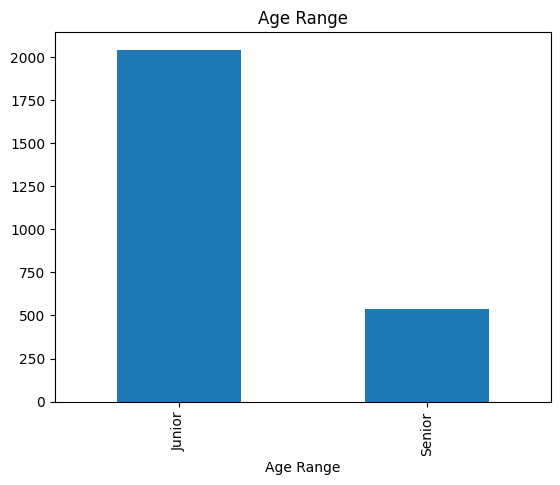

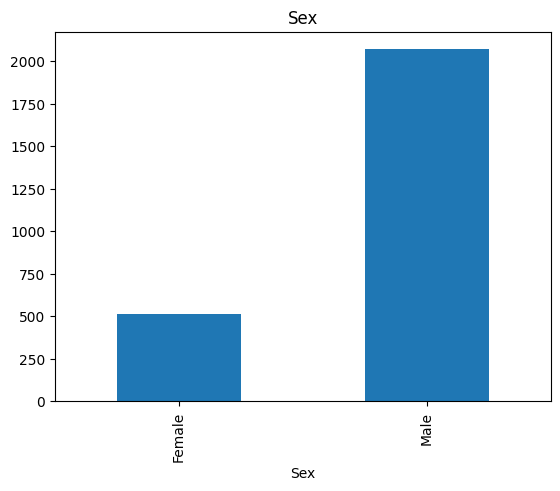

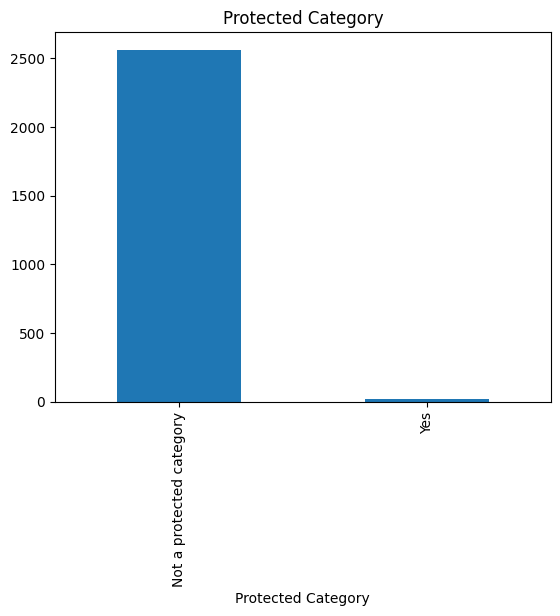

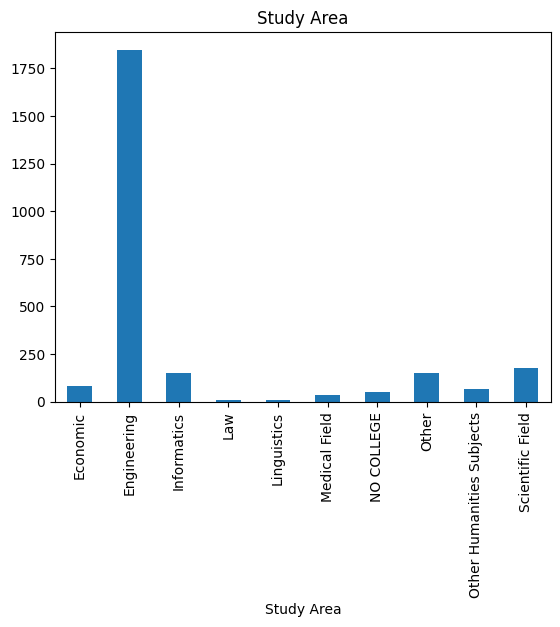

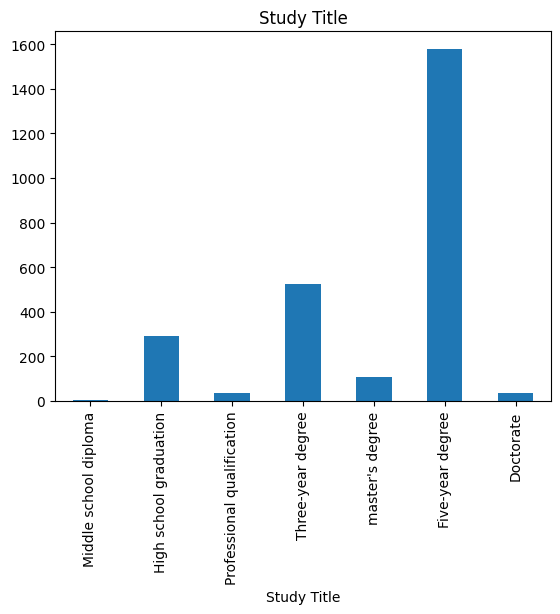

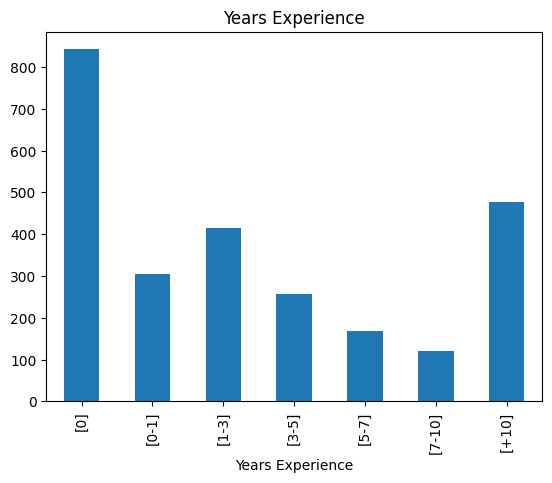

In [213]:
lookups = ['Age Range', 'Sex', 'Protected Category', 'Study Area', 'Study Title', 'Years Experience']
for lookup in lookups:
    mapping = {v: k for k, v in encoding_mappings[lookup].items()}
    codes = sorted(mapping.keys())
    distrib = Counter(df[f"{lookup}_encoded"])
    print(f"Distribution of {lookup}: {distrib}")
    labels = [mapping[c] for c in codes]
    counts = [distrib[c] for c in codes]
    distrib_df = pd.DataFrame({lookup: labels, 'Count': counts})
    distrib_df.head(20).plot(x=lookup, y='Count', kind='bar', legend=False)
    plt.title(lookup)

#### Correlation Matrix

<Axes: >

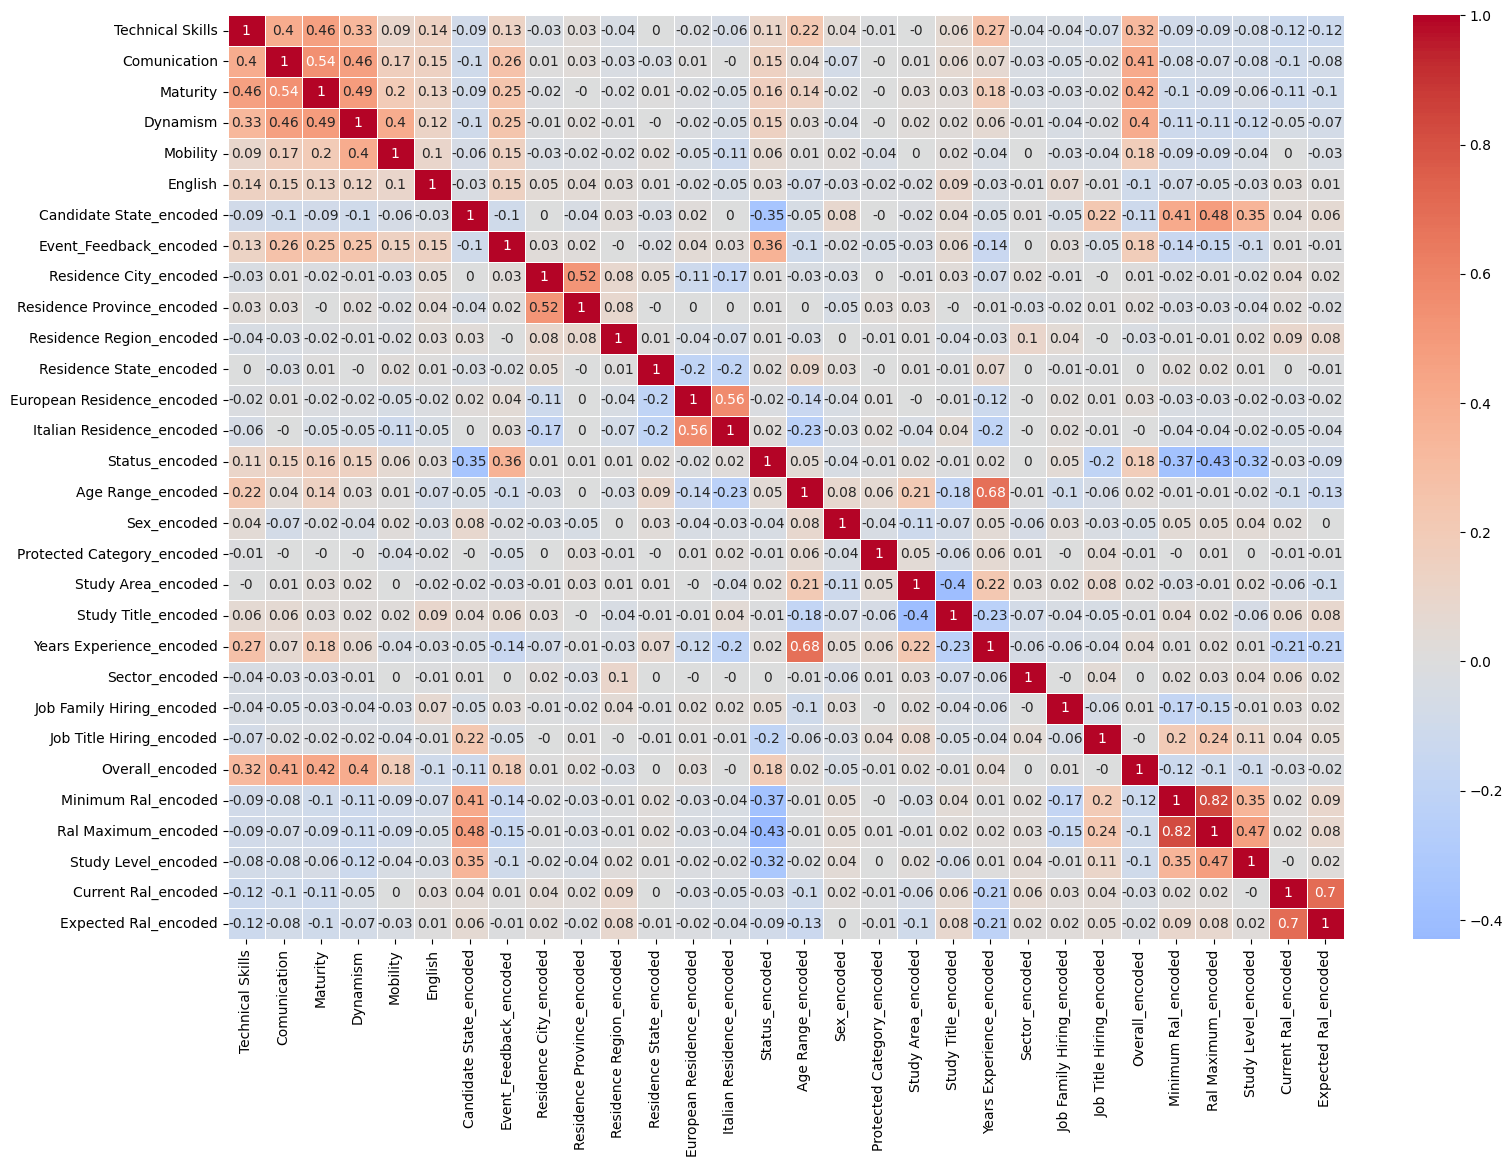

In [214]:
plt.figure(figsize=(18, 12))
sns.heatmap(df.corr().round(2), annot=True, cmap='coolwarm', center=0, linewidths=.5)

### Visualize Percentage of Positive Status inside each class

In [215]:
print(encoding_mappings)

{'Candidate State': {'Economic proposal': 0, 'Hired': 1, 'In selection': 2, 'QM': 3, 'Vivier': 4}, 'Event_Feedback': {'KO (language skills)': 0, 'KO (lost availability)': 1, 'KO (manager)': 2, 'KO (mobility)': 3, 'KO (opportunity closed)': 4, 'KO (proposed renunciation)': 5, 'KO (ral)': 6, 'KO (retired)': 7, 'KO (seniority)': 8, 'KO (technical skills)': 9, 'Not Specified': 10, 'OK': 11, 'OK (hired)': 12, 'OK (live)': 13, 'OK (other candidate)': 14, 'OK (waiting for departure)': 15}, 'Residence City': {'ABANO TERME': 0, 'ABBASANTA': 1, 'ABBIATEGRASSO': 2, 'ACCEPTANCE': 3, 'ACERRA': 4, "ACI SANT'ANTONIO": 5, 'ACQUAVIVA DELLE FONTI': 6, 'ACQUAVIVA PICENA': 7, 'ACQUI TERME': 8, 'ADRIATIC DAWN': 9, 'AFFI': 10, 'AFFORI': 11, 'AFRAGOLA': 12, 'AGRATE BRIANZA': 13, 'AGRATE CONTURBIA': 14, 'AGRIGENTO': 15, 'ALBA': 16, 'ALBIATE': 17, 'ALBINEA': 18, 'ALBINO': 19, 'ALBUSCIAGO': 20, 'ALESSANDRIA': 21, 'ALGHERO': 22, 'ALIFE': 23, 'ALLUMIERE': 24, 'ALPIGNANO': 25, 'ALSENO': 26, 'ALTAMURA': 27, 'ALTOFO

In [216]:
sensitive = ['Sex_encoded', 'Age Range_encoded', 'Protected Category_encoded']

status_map = {v: k for k, v in encoding_mappings['Status'].items()}

for feature in sensitive:
    cat_map = {v: k for k, v in encoding_mappings[feature.replace('_encoded', '')].items()}
    percentage = df.groupby(feature)['Status_encoded'].mean().mul(100).round(2) # Positive
    for cat, perc in percentage.items():
        print(f"Feature: {feature} - Feature Val: {cat_map[cat]} - Status Val: {status_map[1]}-> {perc:.2f}%")
        print(f"Feature: {feature} - Feature Val: {cat_map[cat]} - Status Val: {status_map[0]}-> {(100 - perc):.2f}%")

Feature: Sex_encoded - Feature Val: Female - Status Val: Positive-> 41.02%
Feature: Sex_encoded - Feature Val: Female - Status Val: Negative-> 58.98%
Feature: Sex_encoded - Feature Val: Male - Status Val: Positive-> 35.80%
Feature: Sex_encoded - Feature Val: Male - Status Val: Negative-> 64.20%
Feature: Age Range_encoded - Feature Val: Junior - Status Val: Positive-> 35.67%
Feature: Age Range_encoded - Feature Val: Junior - Status Val: Negative-> 64.33%
Feature: Age Range_encoded - Feature Val: Senior - Status Val: Positive-> 41.26%
Feature: Age Range_encoded - Feature Val: Senior - Status Val: Negative-> 58.74%
Feature: Protected Category_encoded - Feature Val: Not a protected category - Status Val: Positive-> 36.87%
Feature: Protected Category_encoded - Feature Val: Not a protected category - Status Val: Negative-> 63.13%
Feature: Protected Category_encoded - Feature Val: Yes - Status Val: Positive-> 31.58%
Feature: Protected Category_encoded - Feature Val: Yes - Status Val: Negative

## Save to File

In [217]:
df.to_excel(PATH + 'data/Dataset_Preprocessed.xlsx', index=False)

## Chi-squared Tests

In [219]:
# Tabelle di contingenza
contingency_sex    = pd.crosstab(df['Sex_encoded'], df['Status_encoded'])
contingency_age    = pd.crosstab(df['Age Range_encoded'], df['Status_encoded'])
contingency_region = pd.crosstab(df['Residence Region_encoded'], df['Status_encoded'])

# Chi-squared tests
tables = {
    'Sex': contingency_sex,
    'Age Range': contingency_age,
    'Residence Region': contingency_region
}
for var, table in tables.items():
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    test_name = 'Chi-squared'
    
    # se 2×2 e attese <5 → Fisher’s exact
    if table.shape == (2,2) and (expected < 5).any():
        _, p = fisher_exact(table)
        test_name = "Fisher's exact"
    
    n = table.values.sum()
    k = min(table.shape)
    cramer_v = np.sqrt(chi2 / (n * (k-1)))
    
    # Stampa a video
    print(f"--- {var} ---")
    print("Expected frequencies:")
    print(pd.DataFrame(expected, index=table.index, columns=table.columns))
    print()
    print(f"{test_name}: χ² = {chi2:.2f}, p = {p:.3f}, dof = {dof}, Cramér’s V = {cramer_v:.3f}")
    print("Conclusion: Significant association between two variables (Dependent)" if p < 0.05 else "Conclusion: No significant association between two variables (Independent)")
    print()
    

--- Sex ---
Expected frequencies:
Status_encoded            0           1
Sex_encoded                            
0                323.420604  188.579396
1               1307.579396  762.420604

Chi-squared: χ² = 4.80, p = 0.028, dof = 1, Cramér’s V = 0.043
Conclusion: Significant association between two variables (Dependent)

--- Age Range ---
Expected frequencies:
Status_encoded               0           1
Age Range_encoded                         
0                  1291.155693  752.844307
1                   339.844307  198.155693

Chi-squared: χ² = 5.74, p = 0.017, dof = 1, Cramér’s V = 0.047
Conclusion: Significant association between two variables (Dependent)

--- Residence Region ---
Expected frequencies:
Status_encoded                     0           1
Residence Region_encoded                        
0                          29.057320   16.942680
1                           0.631681    0.368319
2                          24.003873   13.996127
3                          17.05

In [225]:
for feature in df.columns:
    print(f'Feature: {feature} -- {list(df[feature].unique())}')

Feature: Technical Skills -- [3.0, 2.0, 1.0, 4.0]
Feature: Comunication -- [2.0, 3.0, 1.0, 4.0]
Feature: Maturity -- [3.0, 2.0, 1.0, 4.0]
Feature: Dynamism -- [3.0, 2.0, 1.0, 4.0]
Feature: Mobility -- [2.0, 1.0, 3.0, 4.0]
Feature: English -- [4.0, 3.0, 1.0, 2.0]
Feature: Candidate State_encoded -- [1, 4, 3, 2, 0]
Feature: Event_Feedback_encoded -- [11, 10, 9, 15, 5, 13, 3, 2, 7, 12, 6, 8, 14, 4, 1, 0]
Feature: Residence City_encoded -- [689, 218, 157, 636, 39, 394, 194, 43, 253, 136, 335, 351, 50, 247, 731, 587, 658, 137, 383, 266, 628, 93, 501, 516, 403, 179, 377, 639, 429, 499, 52, 696, 255, 598, 241, 507, 614, 195, 453, 254, 309, 290, 58, 331, 399, 226, 727, 15, 397, 422, 528, 459, 684, 582, 328, 642, 653, 243, 616, 477, 540, 14, 17, 238, 297, 70, 267, 86, 27, 337, 219, 34, 176, 704, 533, 312, 566, 600, 502, 6, 400, 554, 552, 411, 196, 656, 412, 647, 551, 127, 463, 406, 447, 341, 462, 87, 227, 125, 323, 543, 456, 445, 214, 450, 504, 736, 662, 82, 584, 295, 88, 79, 493, 479, 690, 401

In [ ]:
selection_order = [
    'Imported', 'In selection', 'First contact',
    'QM', 'Vivier', 'Economic proposal', 'Hired'
]
lookouts = ['Sex_encoded', 'Age Range_encoded', 'Residence Region_encoded']

for lookout in lookouts:
    contingency_tables = {}
    cat_map = {v: k for k, v in encoding_mappings[lookout.replace('_encoded', '')].items()}
    for i, state in enumerate(selection_order):
        if state not in encoding_mappings['Candidate State']:
            continue

        post_states = selection_order[i+1:]
        if not post_states:
            continue

        state_code = encoding_mappings['Candidate State'][state]
        post_state_codes = [encoding_mappings['Candidate State'][s] for s in post_states if s in encoding_mappings['Candidate State']]

        df_state      = df[df['Candidate State_encoded'] == state_code]
        df_post_state = df[df['Candidate State_encoded'].isin(post_state_codes)]

        table = pd.DataFrame({
            f'Post {state}': df_post_state.groupby(lookout, observed=True).size(),
            state:            df_state.groupby(lookout, observed=True).size()
        }).fillna(0).astype(int)
        table.index = table.index.map(cat_map)
        contingency_tables[state] = table

    for var, table in contingency_tables.items():
        if table.empty or table.values.sum() == 0:
            continue

        chi2, p, dof, expected = chi2_contingency(table, correction=False)
        test_name = 'Chi-squared'
        if table.shape == (2,2) and (expected < 5).any():
            _, p = fisher_exact(table)
            test_name = "Fisher's exact"

        n = table.values.sum()
        k = min(table.shape)
        cramer_v = np.sqrt(chi2 / (n * (k-1)))

        print(f"--- {var} (by {lookout}) ---")
        print(table, "\n")
        print("Expected frequencies:")
        print(pd.DataFrame(expected, index=table.index, columns=table.columns), "\n")
        print(f"{test_name}: χ²={chi2:.2f}, p={p:.3f}, dof={dof}, Cramér’s V={cramer_v:.3f}")
        print("Dependent" if p<0.05 else "Independent", "\n")

## Train

### Dataset Preparation

In [ ]:
df = shuffle(df, random_state=random_seed)
X_full = df.drop(columns=['STATUS'])
y = df['STATUS']
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size=0.2, random_state=random_seed, stratify=y)

X = df.drop(columns=['STATUS', 'sex'])
y = df['STATUS']
s = df['sex']
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, s, test_size=0.2, random_state=random_seed, stratify=y)

In [ ]:
train_df = X_train.copy()
train_df['target'] = y_train.values
train_df['sex'] = s_train.values

test_df = X_test.copy()
test_df['target'] = y_test.values
test_df['sex'] = s_test.values

train_ds = StandardDataset(
    train_df,
    label_name='target',
    favorable_classes=[1],
    protected_attribute_names=['sex'],
    privileged_classes=[[1]]
)

test_ds = StandardDataset(
    test_df,
    label_name='target',
    favorable_classes=[1],
    protected_attribute_names=['sex'],
    privileged_classes=[[1]]
)

In [ ]:
lfr = LFR(unprivileged_groups=[{'sex': 0}], privileged_groups=[{'sex': 1}], k=10, Ax=5, Ay=5, Az=10, max_iter=50, verbose=1)

lfr = lfr.fit(train_ds)
X_train_lfr = lfr.transform(train_ds)
X_train_lfr_df = pd.DataFrame(X_train_lfr.features, columns=train_ds.feature_names)


clf = LogisticRegression(solver='liblinear')
clf.fit(X_train_lfr_df, y_train)
preds_lfr = clf.predict(pd.DataFrame(lfr.transform(test_ds).features, columns=train_ds.feature_names))

In [ ]:
cr = CorrelationRemover(sensitive_feature_ids=[train_ds.feature_names.index('sex')])

X_train_cr = cr.fit_transform(X_train)
X_train_cr_df = pd.DataFrame(X_train_cr.features, columns=train_ds.feature_names)

X_test_cr  = cr.transform(X_test)
X_test_cr_df = pd.DataFrame(X_test_cr.features, columns=train_ds.feature_names)

In [ ]:
gfc = GerryFairClassifier(
    unprivileged_groups=[{'sex': 0}],
    privileged_groups=[{'sex': 1}],
    estimator=LogisticRegression(solver='liblinear'),
    constraints='demographic_parity'
)
gfc.fit(train_ds)
pred_gfc = gfc.predict(test_ds)

In [ ]:
pr = PrejudiceRemover(
    sensitive_attr='sex',
    eta=25.0
)
pr.fit(train_ds)
pred_pr = pr.predict(test_ds)

In [ ]:
mfc = MetaFairClassifier(
    unprivileged_groups=[{'sex': 0}],
    privileged_groups=[{'sex': 1}],
    sensitive_attr='sex',
    tau=0.8
)
mfc.fit(train_ds)
pred_mfc = mfc.predict(test_ds)

In [ ]:
eop = EqOddsPostprocessing(
    unprivileged_groups=[{'sex': 0}],
    privileged_groups=[{'sex': 1}]
)
eop = eop.fit(train_ds, gfc.predict(train_ds))
pred_eop = eop.predict(test_ds)

In [ ]:
roc = RejectOptionClassification(
    unprivileged_groups=[{'sex': 0}],
    privileged_groups=[{'sex': 1}],
    low_class_thresh=0.01,
    high_class_thresh=0.99,
    num_class_thresh=100,
    metric_name='Average odds difference'
)
roc = roc.fit(train_ds, gfc.predict(train_ds))
pred_roc = roc.predict(test_ds)

In [ ]:
def compute_fairness_metrics(y_true, y_pred, sensitive_features, label=None):
    mf = MetricFrame(
        metrics={
            'selection_rate': selection_rate,
            'dp_diff': demographic_parity_difference,
            'eo_diff': equalized_odds_difference,
            'fpr': false_positive_rate,
            'fnr': false_negative_rate,
            'count': count
        },
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )
    if label:
        print(f"=== {label} ===")
    print(mf.by_group)
    print("Overall:", mf.overall, "\n")
    return mf

In [ ]:
# Pre-Processing
compute_fairness_metrics(y_test, preds_lfr, s_test, label="LFR + LogisticRegression")

# In-processing
compute_fairness_metrics(y_test, pred_gfc.ravel(), s_test, label="GerryFairClassifier")
compute_fairness_metrics(y_test, pred_pr.ravel(), s_test, label="PrejudiceRemover")
compute_fairness_metrics(y_test, pred_mfc.ravel(), s_test, label="MetaFairClassifier")

# Post-processing
compute_fairness_metrics(y_test, pred_eop.ravel(), s_test, label="EqOddsPostprocessing")
compute_fairness_metrics(y_test, pred_roc.ravel(), s_test, label="RejectOptionClassification")

### Models

In [ ]:
def create_model(seed):
    tf.random.set_seed(seed)
    model = Sequential()
    model.add(Dense(128, input_dim=22, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(),
    'KNN': KNeighborsClassifier(),
    'Neural Network': create_model(random_seed)
}

In [ ]:
metrics = []
predictions = {}

for name, model in models.items():
    if name in ['Linear Regression', 'Decision Tree', 'Naive Bayes', 'XGBoost', 'KNN']:
        model.fit(X_train_full, y_train_full)
    elif name in ['Neural Network']:
        model.fit(X_train_full, y_train_full, epochs=15, batch_size=64, validation_split=0.2)
    else:
        print("Error in Models!"); break

    y_pred = model.predict(X_test_full)

    if name in ['Linear Regression', 'XGBoost', 'Neural Network']:
        y_pred = (y_pred > 0.5).astype(int)

    accuracy = round(accuracy_score(y_test_full, y_pred), 3)
    precision = round(precision_score(y_test_full, y_pred), 3)
    recall = round(recall_score(y_test_full, y_pred), 3)
    f1 = round(f1_score(y_test_full, y_pred), 3)
    roc_auc = round(roc_auc_score(y_test_full, y_pred), 3)

    metrics.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'ROC AUC': roc_auc
    })
    predictions[name] = y_pred

metrics = pd.DataFrame(metrics)
predictions_df = pd.DataFrame({
    'Linear Regression' : predictions['Linear Regression'],
    'Decision Tree' : predictions['Decision Tree'],
    'Naive Bayes' : predictions['Naive Bayes'],
    'XGBoost' : predictions['XGBoost'],
    'kNN' : predictions['KNN'],
    'Neural Network' : predictions['Neural Network']
})

## Fairness Metrics

#### **3.1 Demographic Parity**

In [ ]:
sensitive_features = [' Sex_encoded', ' Age Range_encoded', ' Citizenship_encoded', ' Protected category_encoded']
non_sensitive_features = ['Technical Skills', 'Comunication', 'Maturity', 'Dynamism', 'Mobility',
       'English', ' Study area_encoded', ' Study Title_encoded', ' Years Experience_encoded', ' Sector_encoded', ' Job Family Hiring_encoded',
       ' Job Title Hiring_encoded', ' Overall_encoded', ' Years Experience.1_encoded',' Minimum Ral_encoded', ' Ral Maximum_encoded',
       ' Study Level_encoded', 'Current Ral_encoded', 'Expected Ral_encoded']
models_list = [model for model in models]
tolerance = 0.15
significance_level = 0.1

In [ ]:
def calculate_demographic_parity(predictions, sensitive_attribute, name, significance_level, tolerance, activate_check=False):

    df = pd.DataFrame({
        'predictions': predictions,
        'sensitive_attribute': sensitive_attribute
    })
    prop = df.groupby('sensitive_attribute')['predictions'].mean()
    
    if activate_check:
        print(f"===\n{name}\n{prop}")

    if prop.shape[0] == 2:
        return 'T' if (prop.max() - prop.min()) <= tolerance else False
    else:
        contingency_table = pd.crosstab(df['predictions'], df['sensitive_attribute'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        if activate_check and (expected < 5).any():
            print(f"Sparse contingency for {name}")
                
        return 'T' if p > significance_level else False


In [ ]:
table = []
for model in models:
    row = []
    for sensitive_feature in sensitive_features:
        result = calculate_demographic_parity(predictions[model], X_test_full[sensitive_feature], sensitive_feature, significance_level, tolerance, activate_check=True)
        row.append(result)
    table.append(row)
sf_df = pd.DataFrame(table, index = models_list, columns=sensitive_features)

#### **3.2 Equalized odds**

In [ ]:
def calculate_equalized_odds(predictions, true_labels, sensitive_attribute, name, tolerance, activate_check=False):
    df = pd.DataFrame({
        'predictions': predictions,
        'true_labels': true_labels,
        'sensitive_attribute': sensitive_attribute
    })
    tprs, fprs = [], []
    for _, group_df in df.groupby('sens'):
        tn, fp, fn, tp = confusion_matrix(group_df['true_labels'], group_df['predictions'], labels=[0, 1]).ravel()
        tprs.append(tp / (tp + fn) if tp + fn != 0 else 0)
        fprs.append(fp / (fp + tn) if fp + tn != 0 else 0)

    max_tpr_diff = max(tprs) - min(tprs)
    max_fpr_diff = max(fprs) - min(fprs)

    if activate_check:
            print(f"===\n{name}\nMax FPR diff: {max_fpr_diff}\nMax TPR diff: {max_tpr_diff}")

    return 'T' if (max_tpr_diff <= 2 * tolerance and max_fpr_diff <= 2 * tolerance) else False

In [ ]:
table = []
for model in models:
    row = []
    for sensitive_feature in sensitive_features:
        result = calculate_equalized_odds(predictions[model], y_test_full, X_test_full[sensitive_feature], sensitive_feature, tolerance, activate_check=False)
        row.append(result)
    table.append(row)
sf_df = pd.DataFrame(table, index = models_list, columns=sensitive_features)